In [23]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.autograd import Variable 

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image
from tqdm import tqdm


In [34]:
data_df = pd.read_csv("../Datasets/characters/data.csv")[["file_name", "text"]]
indexdict = {}
indexing = ['0',',', '2', '3', '4', '5', '6', '7', '8', '9', 'B', 'Delta', 'E', 'R', 'a', 'alpha', 'beta', 'bracket', 'cos', 'd', 'div', 'f', 'forall', 'g', 'gamma', 'geq', 'h', 'i', 'in', 'infty', 'int', 'k', 'leq', 'lim', 'log', 'lt', 'm', 'mu', 'n', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'q', 's', 'sigma', 'sin', 'sqrt', 'sum', 't', 'tan', 'theta', 'times', 'u', 'v', 'w', 'x', 'y', 'z', '!', '(', ')', '+', '-']
for i in range(0, len(indexing)):
    indexdict[indexing[i]] = i
data_df.head()



,file_name,text
0,SQUARE_MATH_u_2_464.png_0,u
1,SQUARE_MATH_u_0_207.png_1,u
2,SQUARE_MATH_u_4_757.png_2,u
3,SHORT_MATH_u_6_259.png_3,u
4,SQUARE_MATH_u_3_90.png_4,u


In [40]:
transform = transforms.Compose([
    transforms.Resize((50,50)),
    
    transforms.ToTensor()
])
class WholeDataset(Dataset):
    def __len__(self):
        return len(data_df)

    def __getitem__(self, idx):
        filename,label = data_df.iloc[idx][["file_name", "text"]]
        img = transform(Image.open("../Datasets/characters/images/"+filename).convert('L'))
        labelind = indexdict[label]
        return img, labelind
    


dataset = WholeDataset()

train_len = int(len(dataset)*0.8)      
val_len = int(len(dataset)*0.1)
test_len = len(dataset) - train_len -val_len
train_set, val_set, test_set = random_split(dataset,[train_len,val_len,test_len])

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=32)

In [41]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = conv1 = nn.Sequential(  
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, 
                      stride=1, padding=1)  ,                         
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = conv2 = nn.Sequential(         
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, 
                      stride=1, padding=1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32* 12 * 12, len(indexing))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [46]:
device = torch.device("mps")
model = CNN().to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)  

for epoch in range(5):
    model.train()
    i = 0;
    iterations = tqdm(train_dataloader,desc='Bar desc', leave=True)
    for images, labels in iterations:#tqdm(train_dataloader):
        
        if (i+1) % 50 == 0:
            iterations.set_description("Loss: " +str(round( loss.item(),4)))
            iterations.refresh()
        i+=1
        images, labels = Variable(images).to(device), Variable(labels).to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()
        
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in tqdm(val_dataloader):
            images, labels = Variable(images).to(device), Variable(labels).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        # Print the accuracy
        print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")
        
    torch.save(model, "models/characters_no_"+str(epoch))

100%|████████████████████████████████████████| 444/444 [00:03<00:00, 117.46it/s]


Epoch 1: Accuracy = 92.82%


100%|████████████████████████████████████████| 444/444 [00:03<00:00, 117.29it/s]


Epoch 2: Accuracy = 93.95%


100%|████████████████████████████████████████| 444/444 [00:03<00:00, 116.72it/s]


Epoch 3: Accuracy = 93.94%


100%|████████████████████████████████████████| 444/444 [00:03<00:00, 114.02it/s]


Epoch 4: Accuracy = 93.85%


100%|████████████████████████████████████████| 444/444 [00:04<00:00, 110.98it/s]

Epoch 5: Accuracy = 93.85%


In [47]:
model = torch.load("models/characters_no_2")

In [48]:
model.eval();
all_preds = []
all_labels = []
count = 0
for images, labels in tqdm(test_dataloader):
    test_output = model(images.to(device))
    
    
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    count+=1
    
    if(len(labels)==32):
        all_preds += [int(a) for a in pred_y]
        all_labels+=[int(a) for a in labels]
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

100%|█████████████████████████████████████████| 444/444 [00:05<00:00, 74.66it/s]


Overall accuracy:  0.9363713318284425


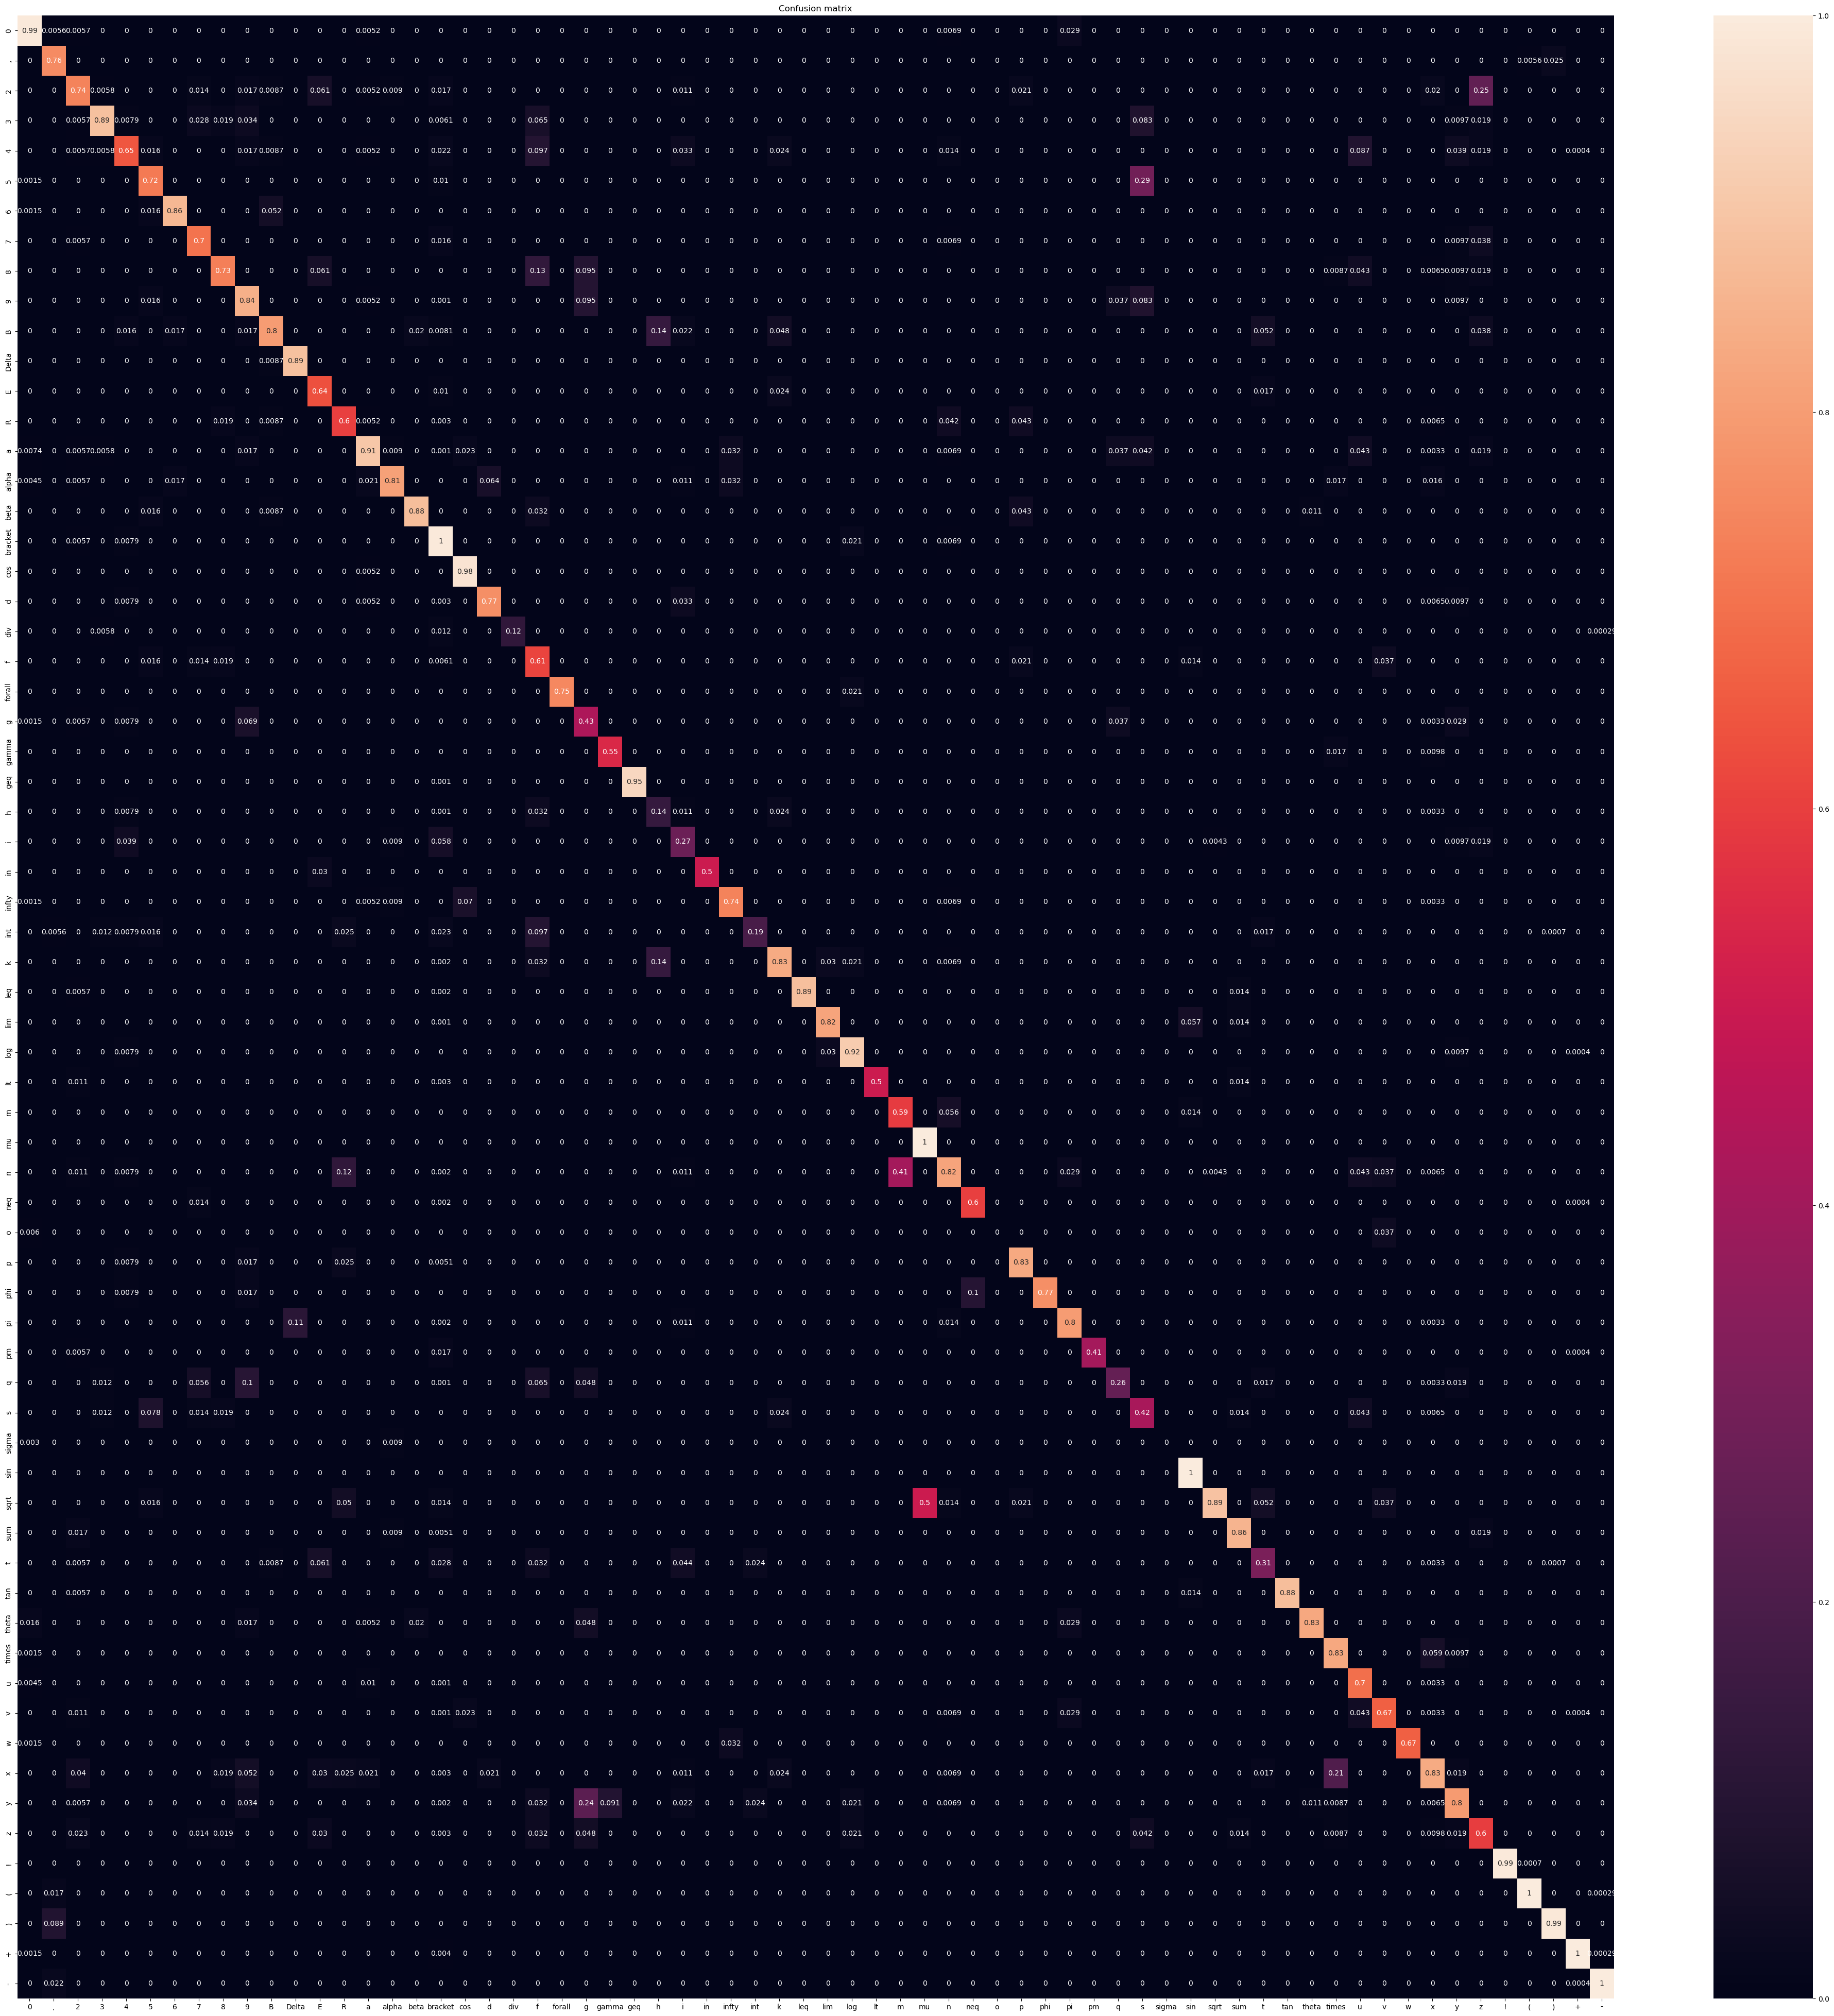

In [49]:
print("Overall accuracy: ",np.sum(all_labels == all_preds)/ len(all_preds))
cf_matrix = confusion_matrix(all_labels,all_preds)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in indexing],
                     columns = [i for i in indexing])
plt.figure(figsize = (50,50))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True)
plt.show()

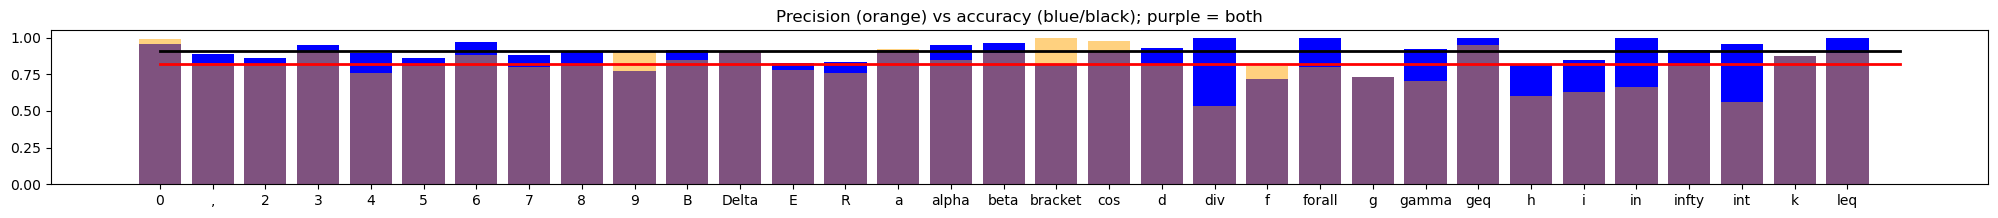

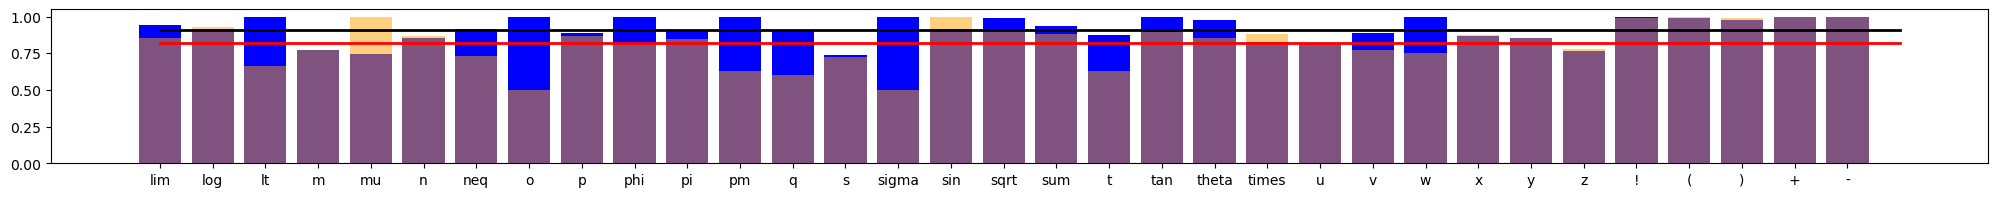

In [67]:

recalls = []
precisions = []
for i in range(0,len(indexing)):

    char = indexing[i]

    labi = np.where(all_labels ==i)[0]
    predi =  np.where(all_preds ==i)[0]
    tp = (set((labi)).union((predi)))
    fp = set(labi) - set(predi)
    fn = set(predi) - set(labi)

    recall = len(tp)/(len(tp)+len(fn)+0.01)
    precision = len(tp)/(len(tp) + len(fp)+0.01)
    
    recalls.append(recall)
    precisions.append(precision)
    
    
plotlen = len(recalls)//2


plt.figure(figsize = (25,2))
plt.title("Precision (orange) vs accuracy (blue/black); purple = both");
plt.bar([i for i in range(0,plotlen)],recalls[0:plotlen], tick_label = indexing[0:plotlen], color = "blue")
plt.bar([i for i in range(0,plotlen)],precisions[0:plotlen], tick_label = indexing[0:plotlen], color = "orange",alpha = 0.5)
plt.plot([0,plotlen], 2*[np.mean(recalls)], color = "black", linewidth = 2)
plt.plot([0,plotlen], 2*[np.mean(precisions)], color = "red", linewidth = 2)

plt.figure(figsize = (25,2))
plt.bar([i for i in range(0,plotlen)],recalls[plotlen:], tick_label = indexing[plotlen:], color = "blue")
plt.bar([i for i in range(0,plotlen)],precisions[plotlen:], tick_label = indexing[plotlen:], color = "orange",alpha = 0.5)
plt.plot([0,plotlen], 2*[np.mean(recalls)], color = "black", linewidth = 2)
plt.plot([0,plotlen], 2*[np.mean(precisions)], color = "red", linewidth = 2);

